<a href="https://colab.research.google.com/github/ttderessa/Temesgen-Deressa/blob/main/DL_SFA_and_TD_SFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking for invalid data:
code          1
hhcode        1
wintert       1
springt       1
summert       1
             ..
ah            0
ai            0
al            0
ak            0
hhsize_01    48
Length: 84, dtype: int64
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 4.1093 - val_loss: 2.7729
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7613 - val_loss: 2.4687
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4379 - val_loss: 2.2056
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.0017 - val_loss: 1.9886
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7234 - val_loss: 1.8154
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9901 - val_loss: 1.6628
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8169 - val_loss: 1.5301
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9257 - val_loss: 1.4167
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5412 - val_loss: 1.3255
Epoch 10/100
7/7

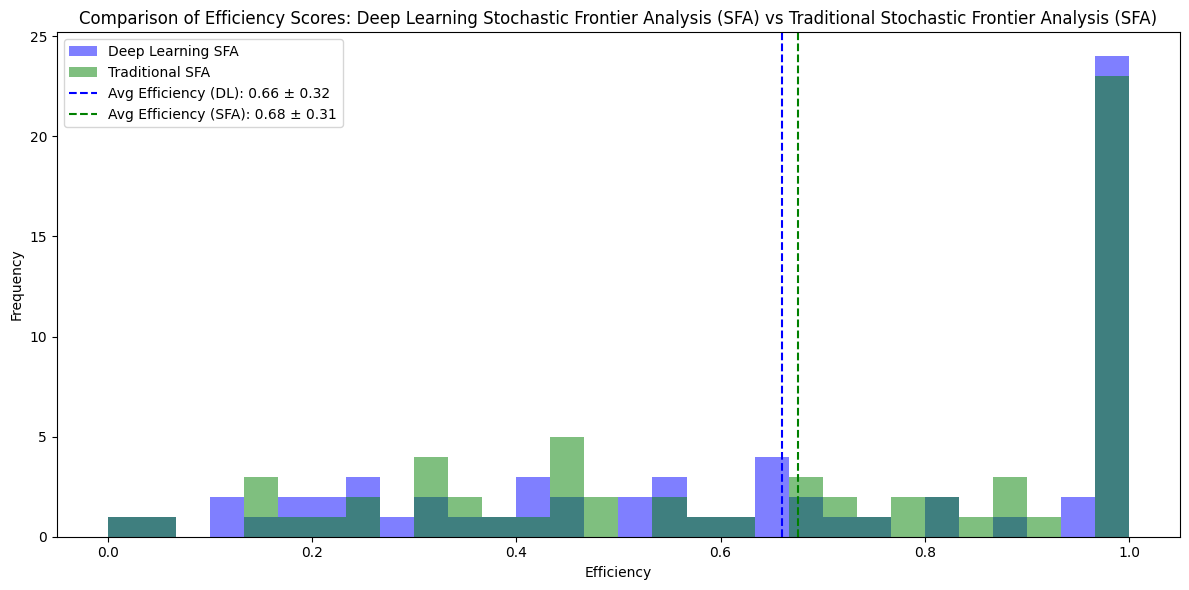


Model Comparison Summary:
+-----------------+-------------------+-----------------+
|     Metric      | Deep Learning SFA | Traditional SFA |
+-----------------+-------------------+-----------------+
| Mean Efficiency |      0.6601       |     0.6754      |
| Std Efficiency  |      0.3240       |     0.3125      |
+-----------------+-------------------+-----------------+


In [ ]:

# Step 1: import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from tabulate import tabulate

# Step 2: Load the Dataset
data = pd.read_stata('/content/Efficiency.dta')

# Step 3: Map Original Column Names to Updated Names
feature_dict = {
    'grrv': 'gross_revenue',  # Output: Gross Revenue
    'fert': 'fertilizer_applied',  # Input: Fertilizer Applied
    'lab': 'labor_input',  # Input: Labor Input
    'trac': 'tractor_power',  # Input: Tractor Power
    'anim': 'animal_power',  # Input: Animal Power
    'area': 'area_cultivated',  # Input: Area Cultivated
    'seed': 'seed_applied'  # Input: Seed Applied
}

data.rename(columns=feature_dict, inplace=True)

# Step 4: Check for Invalid Data
print("Checking for invalid data:")
print(data.isnull().sum())
#print(data.describe())

data = data.dropna()

# Step 5: Preprocess the Data
X = data[['fertilizer_applied', 'labor_input', 'tractor_power',
          'animal_power', 'area_cultivated', 'seed_applied']].values
y = data['gross_revenue'].values

# Step 6: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Standardize the Data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Step 8: Define the Deep Learning Model
def build_sfa_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(inputs)
    x = layers.Dropout(0.2)(x)  # Add dropout for regularization
    frontier = layers.Dense(1, activation='linear')(x)
    inefficiency_term = layers.Dense(1, activation='softplus')(x)
    outputs = frontier - inefficiency_term
    model = models.Model(inputs, outputs)
    return model

# Step 9: Build and Compile the Model
model = build_sfa_model(X_train.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Step 10: Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Step 11: Train the Model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

# Step 12: Evaluate the Model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Step 13: Predict on Test Data
y_pred = model.predict(X_test)

# Step 14: Inverse Transform Predictions and Actual Values
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 15: Calculate Efficiency Scores
efficiency_scores = np.clip(y_test_original / y_pred_original, 0, 1)

# Step 16: Print Some Results
print("Predicted vs Actual Efficiency Scores:")
for i in range(10):
    print(f"Predicted: {y_pred_original[i]:.2f}, Actual: {y_test_original[i]:.2f}, Efficiency: {efficiency_scores[i]:.2f}")

# Step 17: Implement Traditional SFA Using SciPy
def sfa_log_likelihood(params, X, y):
    """
    Log-likelihood function for the Stochastic Frontier Analysis (SFA) model.
    """
    beta = params[:-2]  # Coefficients for inputs
    sigma_v = params[-2]  # Standard deviation of the noise term (v)
    sigma_u = params[-1]  # Standard deviation of the inefficiency term (u)

    y_pred = np.dot(X, beta)
    residuals = y - y_pred

    sigma = np.sqrt(sigma_v**2 + sigma_u**2)
    lambda_ = sigma_u / sigma_v
    epsilon = residuals / sigma
    ll = np.log(2 / sigma) + norm.logcdf(-epsilon * lambda_) + norm.logpdf(epsilon)
    return -np.sum(ll)  # Minimize negative log-likelihood

# Initial parameters for MLE
initial_params = np.zeros(X_train.shape[1] + 2)  # Coefficients + sigma_v + sigma_u
initial_params[-2] = 1.0  # sigma_v
initial_params[-1] = 1.0  # sigma_u

# Perform MLE
result = minimize(sfa_log_likelihood, initial_params, args=(X_train, y_train), method='L-BFGS-B')

# Predict using the traditional SFA model
beta = result.x[:-2]
y_pred_sfa = np.dot(X_test, beta)

# Inverse transform the predictions
y_pred_sfa_original = scaler_y.inverse_transform(y_pred_sfa.reshape(-1, 1)).flatten()

# Calculate efficiency scores for traditional SFA
efficiency_scores_sfa = np.clip(y_test_original / y_pred_sfa_original, 0, 1)

# Step 18: Compare Efficiency Scores
mean_efficiency_dl = np.mean(efficiency_scores)
std_efficiency_dl = np.std(efficiency_scores)

mean_efficiency_sfa = np.mean(efficiency_scores_sfa)
std_efficiency_sfa = np.std(efficiency_scores_sfa)

print("Efficiency Scores Comparison:")
print(f"Deep Learning SFA - Mean Efficiency: {mean_efficiency_dl:.4f}, Std Efficiency: {std_efficiency_dl:.4f}")
print(f"Traditional SFA - Mean Efficiency: {mean_efficiency_sfa:.4f}, Std Efficiency: {std_efficiency_sfa:.4f}")

# Step 19: Plot Comparison of Efficiency Scores
plt.figure(figsize=(12, 6))

# Plot efficiency scores for deep learning-based SFA
plt.hist(efficiency_scores, bins=30, color='blue', alpha=0.5, range=(0, 1), label='Deep Learning SFA')

# Plot efficiency scores for traditional SFA
plt.hist(efficiency_scores_sfa, bins=30, color='green', alpha=0.5, range=(0, 1), label='Traditional SFA')

# Add average lines with standard deviation
plt.axvline(x=mean_efficiency_dl, color='blue', linestyle='--', label=f'Avg Efficiency (DL): {mean_efficiency_dl:.2f} ± {std_efficiency_dl:.2f}')
plt.axvline(x=mean_efficiency_sfa, color='green', linestyle='--', label=f'Avg Efficiency (SFA): {mean_efficiency_sfa:.2f} ± {std_efficiency_sfa:.2f}')

# Add labels and title
plt.title('Comparison of Efficiency Scores: Deep Learning Stochastic Frontier Analysis (SFA) vs Traditional Stochastic Frontier Analysis (SFA)')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Step 20: Print Summary of Model Comparison
comparison_data = [
    ["Mean Efficiency", f"{mean_efficiency_dl:.4f}", f"{mean_efficiency_sfa:.4f}"],
    ["Std Efficiency", f"{std_efficiency_dl:.4f}", f"{std_efficiency_sfa:.4f}"]
]

headers = ["Metric", "Deep Learning SFA", "Traditional SFA"]
print("\nModel Comparison Summary:")
print(tabulate(comparison_data, headers=headers, tablefmt="pretty"))